# Logistic 回归

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

首先我们从logistic_regression_data.txt中读取数据文件的每一行由三个元素构成, x坐标, y坐标, 对应label对不同label的点赋以不同的值之后可以看看数据的情况

In [2]:
with open('data/Logistic_regression.txt') as f:
    data_list = [i.split('\n')[0].split(',') for i in f.readlines()]
    data = [(float(i[0]), float(i[1]), float(i[2])) for i in data_list]

In [3]:
# 标准化
x0_max = max(i[0] for i in data)
x1_max = max(i[1] for i in data)
data = [(i[0]/x0_max, i[1]/x1_max, i[2]) for i in data]

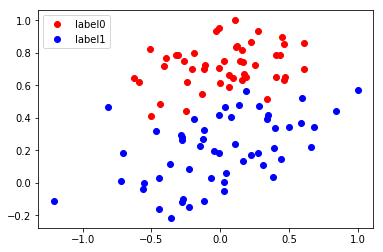

In [4]:
label0 = list(filter(lambda x:x[-1]==0.0, data)) #选择标签为0的点
label1 = list(filter(lambda x:x[-1]==1.0, data)) #选择标签为1的点

x0 = [i[0] for i in label0]
y0 = [i[1] for i in label0]
x1 = [i[0] for i in label1]
y1 = [i[1] for i in label1]

plt.plot(x0, y0, 'ro', label='label0')
plt.plot(x1, y1, 'bo', label='label1')
plt.legend()

## 数据类型转换

In [5]:
np_data = np.array(data, dtype='float32')
x = tf.constant(np_data[:,:2], dtype=tf.float32, name='x')
y = tf.expand_dims(tf.constant(np_data[:,2]), axis=-1)

在之前的练习中, 我们实现了tensorflow下的Sigmoid函数. 实际上我们可以采用"偷懒"的方法--使用tensorflow自带的tf.sigmoid()函数. tensorflow集成了很多这样基本但非常有用的函数, 感兴趣的话可以去 API 手册进行查阅

In [6]:
w = tf.Variable(tf.random_normal((2,1), seed=2017), 
                dtype=tf.float32, name='weight')
b = tf.Variable(0.0, dtype=tf.float32, name='bias')

<img src='img/logistic.png'>

In [7]:
# 使用 tf.sigmoid 将结果映射到 [0, 1] 区间
def logistic_regression(x):
    return tf.sigmoid(tf.matmul(x,w)+b) 

我们先画出模型的初始分类效果

In [8]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

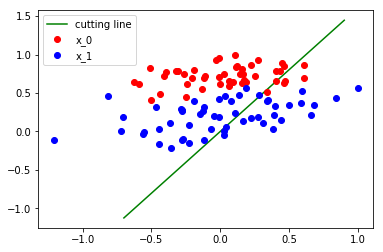

In [9]:
w_numpy = w.eval()
b_numpy = b.eval()

w0 = w_numpy[0]
w1 = w_numpy[1]

plot_x = np.arange(-0.7, 1, 0.1)
plot_y = (-w0 * plot_x - b_numpy) /w1

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(x0, y0, 'ro', label='x_0')
plt.plot(x1, y1, 'bo', label='x_1')
plt.legend(loc='best')

# 优化模型
定义损失函数 $loss=-(y\log(\hat{y})+(1-y)\log(1-\hat{y}))$

In [10]:
def binary_loss(y_pred, y):
    logit = tf.reduce_mean((y*tf.log(y_pred)+(1-y)*tf.log(1-y_pred)))
    return -logit

In [11]:
y_pred = logistic_regression(x)
loss = binary_loss(y_pred, y)

print(loss.eval())

0.6533321


我们继续用梯度下降法来进行模型优化

In [12]:
# 梯度计算以及参数更新
w_grad, b_grad = tf.gradients(loss, [w, b])

lr = 0.1

w_updata = w.assign_sub(lr*w_grad)
b_updata = b.assign_sub(lr*b_grad)

# 更新一次参数
sess.run([w_updata,b_updata])
print(loss.eval())

0.65149015


上面的参数更新方式其实是繁琐的重复操作, 如果我们参数很多(比如>100), 那么按照上面的方式我们需要写非常多的参数更新op, 这是非常耗时的. 然而, 不用担心, tensorflow已经集成了一套方法来做这个事情, 就是tf.train.Optimizer(优化器)

In [13]:
# 首先从tf.train中定义一个优化方法
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1, 
                                              name='optimizer')
# 利用这个优化方法去优化一个损失函数, 得到的这个`op`就是我们想要的
train_op = optimizer.minimize(loss)

现在我们得到了一个train_op, 它实际上等价于上面更新模型的所有操作, 也就是说train_op = 计算梯度 + 参数更新

In [14]:
import time
sess.run(init)
start = time.time()
for i in range(100):
    sess.run(train_op)
    if (i+1)%10 == 0:
        y_true_label = y.eval()
        y_pred_numpy = y_pred.eval()
        y_pred_label = np.greater_equal(y_pred_numpy, 0.5).astype(np.float32)
        accuracy = np.mean(y_pred_label==y_true_label)
        loss_numpy = loss.eval()
        print('Epoch %d  Loss %.2f  Accuracy %.2f'%(i+1, loss_numpy, accuracy))
print()
print('cost time:%.2f'%(time.time()+start))

Epoch 10  Loss 0.61  Accuracy 0.69
Epoch 20  Loss 0.49  Accuracy 0.84
Epoch 30  Loss 0.42  Accuracy 0.94
Epoch 40  Loss 0.38  Accuracy 0.96
Epoch 50  Loss 0.35  Accuracy 0.97
Epoch 60  Loss 0.33  Accuracy 0.97
Epoch 70  Loss 0.31  Accuracy 0.97
Epoch 80  Loss 0.29  Accuracy 0.97
Epoch 90  Loss 0.28  Accuracy 0.97
Epoch 100  Loss 0.27  Accuracy 0.97

cost time:3129261426.64


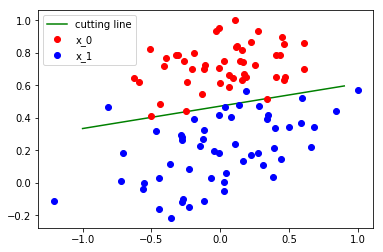

In [16]:
w_numpy = w.eval()
b_numpy = b.eval()

w0 = w_numpy[0]
w1 = w_numpy[1]

plot_x = np.arange(-1, 1, 0.1)
plot_y = (-w0 * plot_x - b_numpy) /w1

plt.plot(plot_x, plot_y, 'g', label='cutting line')
plt.plot(x0, y0, 'ro', label='x_0')
plt.plot(x1, y1, 'bo', label='x_1')
plt.legend(loc='best')

前面我们使用了自己写的 loss，其实tensorflow已经为我们写好了一些常⻅的 loss，比如线性回归里面的 loss是tf.losses.mean_squared_error()，而 Logistic 回归的二分类 loss 在tensorflow中是tf.losses.log_loss<br><a href='https://tensorflow.google.cn/api_docs/python/tf/losses?spm=5176.12282072.0.0.40e3204247ZYaY'>官网loss函数文档<a/>

tensorflow为我们实现的 loss 函数有两个好处，第一是方便我们使用，不需要重复造轮子，第二就是其实现是在底层 C++ 语言上的，所以速度上和稳定性上都要比我们自己实现的要好

In [18]:
loss1 = tf.losses.log_loss(labels=y, predictions=y_pred)
optimizer1 = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer1.minimize(loss1)

In [ ]:
sess.run(init)
start = time.time()
for i in range(100):
    sess.run(train_op)
    if (i+1)%10 == 0:
        y_label = y.eval()
        y_pred_numpy = y_pred.eval()
        y_pred_label = np.greater_equal(y_pred_numpy, 0.5).astype(np.float32)
        accuracy = np.mean(y_pred_label==y_label)
        loss 